In [1]:
'''
https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial
'''
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Importing Scikit-learn KMeans model
from sklearn.cluster import KMeans

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def fix_values(df, fix_dict, col_name):
    for k, v in fix_dict.items():
        entry = df.loc[df[col_name] == k]
        entry[col_name] = v
        df.loc[df[col_name] == k] = entry

# TODO: We need to clean up our summary based on our current status

`time_series_covid19_confirmed_global.csv`
- Latitude/longitude, time series confirmed cases
- Country code not in this file.
- Some country strings are not standard like:  "Korea, South"

`API_EN.POP.DNST_DS2_en_csv_v2_988966.csv`
- Population density for 2019. The 2020 information is not there.

`covid-19-tests-vs-cases-positivity-comparisons.csv`
- Tests that came out positivve
- Missing a lot of numbers for how many tests were performed. We need to grab these numbers from `full-list-covid-19-tests-per-day.csv`


**Plan of action?**

- Are we planning to use the regions/province data? Or will we consolidate it into one country.
- Should we combined all the the fields we want into a single file?
- We need mapping of country codes to country names. Let’s pick one file that looks sane and use it. Then we have to map country names from `time_series_covid19_confirmed_global.csv` back to the correct code.
- We should normalize the start/end dates. We need to get the intersection of start/end dates for all files and only use that.

In [3]:
# The number of confirmed cases per country in a time series format
confirmed_df = pd.read_csv("datasets/time_series_covid19_confirmed_global.csv")

# The number tests performed per day
# Automatically convert dates from column 3 (index 2) to DateTime objects
tests_df = pd.read_csv("datasets/full-list-covid-19-tests-per-day.csv", parse_dates=[2])

# The number of people tested positive per country by day
positive_df = pd.read_csv("datasets/covid-19-tests-vs-cases-positivity-comparisons.csv", parse_dates=[2])

# The GDP per capita for each country for different years
gdp_capita_df = pd.read_csv('datasets/gdp.csv')

# The population, population density, and population (urban only) for each country
population_df = pd.read_csv('datasets/Populations_and_popdensity.csv')

# The centroid latitude and longitude coordinates for each country
centroid_df = pd.read_csv('datasets/country_centroids_az8.csv')

In [4]:
print("Confirmed shape: ", confirmed_df.shape)
confirmed_df.head()

Confirmed shape:  (264, 96)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25


In [5]:
print("Tests performed shape: ", tests_df.shape)
tests_df.head()

Tests performed shape:  (2683, 4)


,Entity,Code,Date,Daily change in total tests
0,Argentina,ARG,2020-04-09,1520
1,Argentina,ARG,2020-04-10,1529
2,Argentina,ARG,2020-04-11,1648
3,Argentina,ARG,2020-04-14,3047
4,Argentina,ARG,2020-04-15,1569


In [6]:
# Remove the province column because it will not be used
confirmed_df.drop("Province/State", axis=1, inplace=True)

# Inspect the country names to make sure they are sane
countries = confirmed_df["Country/Region"]
bad_countries = list(filter(lambda x: "," in x or "*" in x, countries))
print("Bad country strings: ", bad_countries)

# Through manual inspection, we determined that we need to properly change these inconsistent values.
confirmed_fix_dict = {
    "Korea, South": "South Korea",
    "Taiwan*": "Taiwan",
    "US": "United States",
}
print("Bad country fix dict: ", confirmed_fix_dict)

# Fix the values
fix_values(confirmed_df, confirmed_fix_dict, "Country/Region")

# Inspect that the strings are fixed
print(countries[143])  # South Korea
print(countries[207])  # Taiwan
print(countries[225])  # United States
confirmed_df.head()  # Make sure the province column is removed

Bad country strings:  ['Korea, South', 'Taiwan*']
Bad country fix dict:  {'Korea, South': 'South Korea', 'Taiwan*': 'Taiwan', 'US': 'United States'}
South Korea
Taiwan
United States


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25


In [7]:
# Find abnormal country names in the tests performed dataset
pivoted_tests_df = tests_df.pivot(index="Entity", columns="Date", values=["Daily change in total tests"])
abnormal_country_names = list(filter(lambda x: "," in x, pivoted_tests_df.index))
print("Abnormal country names: ")
abnormal_country_names

Abnormal country names: 


['India, people tested',
 'Italy, people tested',
 'Japan, tests performed',
 'United Kingdom, tests performed',
 'United States, specimens tested (CDC)']

In [8]:
# Ensure that all the abnormal country names are ok to remove. We need to check if the country name
# before the comma already exists in the DataFrame. If it does not, that means this is the only information
# we have on the country. We should normalize the country name for those names. If the normalized country
# name does exist as a row, we can remove all rows containing the abnormal country names.
unwanted_indexes = []
tests_fix_dict = {}
for acn in abnormal_country_names:
    normalized_country_name = acn.split(",")[0]
    norm_df = tests_df[tests_df["Entity"] == normalized_country_name]
    ac_df = tests_df[tests_df["Entity"] == acn]
    if norm_df.empty:
        # Keep track of country names we need to modify
        tests_fix_dict[acn] = normalized_country_name        
    else:
        # Accumulate a list of indexes we want to remove
        print("Adding country name to drop list:", acn)
        unwanted_indexes.extend(ac_df.index)
        
# It is important to apply conversions first before removing the unwanted rows. If you try to apply
# the conversions after dropping the row, the indexes would have changed and you would be modifying
# the wrong rows.
print("Tests fix dict:", tests_fix_dict)
fix_values(tests_df, tests_fix_dict, "Entity")
    
print("Unwanted indexes:", unwanted_indexes)
print("Shape before dropping:", tests_df.shape)
# Remove the unwanted rows from the original DataFrame
tests_df.drop(unwanted_indexes, inplace=True)
print("Shape after dropping:", tests_df.shape)
tests_df.head()

Adding country name to drop list: India, people tested
Adding country name to drop list: Italy, people tested
Adding country name to drop list: United Kingdom, tests performed
Adding country name to drop list: United States, specimens tested (CDC)
Tests fix dict: {'Japan, tests performed': 'Japan'}
Unwanted indexes: [916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 1105, 1106, 1107, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 26

,Entity,Code,Date,Daily change in total tests
0,Argentina,ARG,2020-04-09,1520
1,Argentina,ARG,2020-04-10,1529
2,Argentina,ARG,2020-04-11,1648
3,Argentina,ARG,2020-04-14,3047
4,Argentina,ARG,2020-04-15,1569


In [9]:
# Aggregate confirmed cases based on country. This dataset has duplicate countries that have might be tied
# to a different province or state. This however will also sum the latitude and longitudes. In our case 
# this does not matter because we will be replacing these values from another dataset.
group_confirmed_df = confirmed_df.groupby("Country/Region")
confirmed_df = group_confirmed_df.sum()
confirmed_df  # This is a normal DataFrame again with duplicate countries removed

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,...,308,308,374,374,402,418,437,449,466,474
Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [10]:
# Check abnormalities with country string name
gdp_countries = set(gdp_capita_df["Country Name"].values)
gdp_abnormal = list(filter(lambda x: "," in x, gdp_countries))
print("GDB abnormal country names:")
print(gdp_abnormal)

# After inspecting the difference between our `confirmed` and `gdp per capita` datasets, we came up with this
# dictionary
gdp_fix_dict = {
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam": "Brunei",
    "Congo, Dem. Rep.": "Congo (Kinshasa)",
    "Congo, Rep.": "Congo (Brazzaville)",
    "Czech Republic": "Czechia",
    "Egypt, Arab Rep.": "Egypt",
    "Gambia, The": "Gambia",
    "Hong Kong SAR, China": "Hong Kong",
    "Iran, Islamic Rep.": "Iran",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Macao SAR, China": "Macau",
    "Myanmar": "Burma",
    "Korea, Dem. People’s Rep.": "North Korea",
    "Korea, Rep.": "South Korea",
    "Russian Federation": "Russia",
    "Venezuela, RB": "Venezula",
    "Yemen, Rep.": "Yemen",
}

# Fix the values
print("\nGDP fix dict:")
print(gdp_fix_dict)
fix_values(gdp_capita_df, gdp_fix_dict, "Country Name")
gdp_capita_df.head()

GDB abnormal country names:
['Hong Kong SAR, China', 'Korea, Dem. People’s Rep.', 'Yemen, Rep.', 'Micronesia, Fed. Sts.', 'Korea, Rep.', 'Macao SAR, China', 'Venezuela, RB', 'Congo, Rep.', 'Iran, Islamic Rep.', 'Bahamas, The', 'Congo, Dem. Rep.', 'Gambia, The', 'Egypt, Arab Rep.']

GDP fix dict:
{'Bahamas, The': 'Bahamas', 'Brunei Darussalam': 'Brunei', 'Congo, Dem. Rep.': 'Congo (Kinshasa)', 'Congo, Rep.': 'Congo (Brazzaville)', 'Czech Republic': 'Czechia', 'Egypt, Arab Rep.': 'Egypt', 'Gambia, The': 'Gambia', 'Hong Kong SAR, China': 'Hong Kong', 'Iran, Islamic Rep.': 'Iran', 'Kyrgyz Republic': 'Kyrgyzstan', 'Lao PDR': 'Laos', 'Macao SAR, China': 'Macau', 'Myanmar': 'Burma', 'Korea, Dem. People’s Rep.': 'North Korea', 'Korea, Rep.': 'South Korea', 'Russian Federation': 'Russia', 'Venezuela, RB': 'Venezula', 'Yemen, Rep.': 'Yemen'}


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24985.993281,24713.698045,25025.099563,25533.569780,25796.380251,25239.600411,25630.266492,NaN,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773194,59.860874,58.458015,78.706388,82.095231,101.108305,...,591.162346,641.872034,637.165044,613.856333,578.466353,547.228110,556.302139,520.896603,NaN,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4615.468028,5100.095808,5254.882338,5408.410496,4166.979684,3506.072885,4095.812942,3432.385736,NaN,NaN
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4437.178067,4247.614279,4413.081743,4578.666720,3952.829458,4124.108907,4532.890162,5268.848504,NaN,NaN
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,41100.729938,38392.943901,40626.751632,42300.334128,36039.653496,37224.108916,39134.393371,42029.762737,NaN,NaN


In [11]:
# Using the `confirmed` dataset as the primary data source, see if the `tests` and `gdp per capita` datasets are
# missing any countries that we need.
#
# *** We are using this function repeatedly to recheck for abnormalities again after the previous cleaning steps.
confirmed_countries = set(confirmed_df.index)
#print("Confirmed countries:", confirmed_countries)
tests_countries = set(tests_df["Entity"].values)
#print("Tests countries:", tests_countries)
gdp_capita_countries = set(gdp_capita_df["Country Name"].values)
#print("GDP countries:", gdp_countries)

# Perform set operations to find useful information between `confirmed` and `tests` countries
common_confirmed_plus_tests = confirmed_countries & tests_countries
uncommon_confirmed_plus_tests = confirmed_countries ^ tests_countries
confirmed_minus_tests = confirmed_countries - tests_countries

# Perform set operations to find useful information between `confirmed` and `gdp` countries
common_confirmed_plus_gdp_capita = confirmed_countries & gdp_capita_countries
uncommon_confirmed_plus_gdp_capita = confirmed_countries ^ gdp_capita_countries
confirmed_minus_gdp_capita = confirmed_countries - gdp_capita_countries

# Some of the following output is questionable and shouldn't be a country
# Ships:  Diamond Princess, MS Zaandam
print("Countries missing in `GDP per capita` dataset:")
# TODO: How should we impute these values
confirmed_minus_gdp_capita

Countries missing in `GDP per capita` dataset:


{'Diamond Princess',
 'Holy See',
 'MS Zaandam',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Slovakia',
 'Syria',
 'Taiwan',
 'Venezuela',
 'Western Sahara'}

In [12]:
# Every country's `gdp per capita` is empty for 2019 so we can't use it.
print(gdp_capita_df.shape)
print("GDP NULL count for 2019:", gdp_capita_df["2019"].isnull().sum())

# Although we don't have every country in our `gdp per capita` dataset to match every country in the
# `confirmed` dataset, let's at least try to use the latest values for each that exist. We will start
# with the 2018 column and then fill any NaN countries that we need by searching the years backward.
gdp_capita_2018_df = gdp_capita_df[['Country Name','Country Code','2018']]
gdp_capita_2018_df.rename(columns={'2018': 'GDP per capita'}, inplace=True)
gdp_capita_null_df = gdp_capita_2018_df[gdp_capita_2018_df['GDP per capita'].isnull()]
gdp_capita_missing_data = set(gdp_capita_null_df["Country Name"].values)

# Check which countries are missing the `gdp per capita` for 2018. For these countries missing values for
# 2018, let's fill in the missing data for the latest year we can find.
remaining_countries = gdp_capita_missing_data & confirmed_countries

# Walk backwards to search and replace the data with the first one found
for country in remaining_countries:
    for i in range(2017, 1959, -1):
        year = str(i)
        country_gdp_capita = gdp_capita_df[gdp_capita_df["Country Name"] == country]
        if all(country_gdp_capita[year].notna()):
            temp_country = gdp_capita_2018_df[gdp_capita_2018_df["Country Name"] == country]
            temp_country["GDP per capita"] = country_gdp_capita[year]
            gdp_capita_2018_df[gdp_capita_2018_df["Country Name"] == country] = temp_country
            print(f"Found and replaced GDP per capita for {country} using {year} data")
            break

# Extract the data again to make sure the modification happened
gdp_capita_null_df = gdp_capita_2018_df[gdp_capita_2018_df['GDP per capita'].isnull()]
gdp_capita_missing_data = set(gdp_capita_null_df["Country Name"].values)
remaining_countries = gdp_capita_missing_data & confirmed_countries

# This set should be empty
print(remaining_countries)

# This is the DataFrame we should be using from now on for merges
gdp_capita_2018_df.head()

(264, 65)
GDP NULL count for 2019: 264
Found and replaced GDP per capita for San Marino using 2017 data
Found and replaced GDP per capita for Liechtenstein using 2016 data
Found and replaced GDP per capita for Eritrea using 2011 data
Found and replaced GDP per capita for Iran using 2017 data
Found and replaced GDP per capita for South Sudan using 2015 data
set()


,Country Name,Country Code,GDP per capita
0,Aruba,ABW,NaN
1,Afghanistan,AFG,520.896603
2,Angola,AGO,3432.385736
3,Albania,ALB,5268.848504
4,Andorra,AND,42029.762737


In [13]:
# Inspect the dataset
population_df.head()

,Country/Region,Population,Density,Urban Population
0,Afghanistan,38928346,60,9732086.50
1,Albania,2877797,105,1813012.11
2,Algeria,43851044,18,32011262.12
3,American Samoa,55191,276,48568.08
4,Andorra,77265,164,67993.20


In [14]:
# Find common/uncommon countries between `population` and `confirmed` datasets
population_countries = set(population_df["Country/Region"].values)
population_missing = confirmed_countries - population_countries
print("Population dataset is missing:", population_missing)

# Through manual inspection we have created this dictionary to fix the country strings
population_fix_dict = {
    "Brunei ": "Brunei",
    "Côte d'Ivoire": "Cote d'Ivoire",
    "Czech Republic (Czechia)": "Czechia",
    "Congo": "Congo (Brazzaville)",
    "DR Congo": "Congo (Kinshasa)",
    "Myanmar": "Burma",
}

# Fix the values
print("\nPopulation fix dict:", population_fix_dict)
fix_values(population_df, population_fix_dict, "Country/Region")

# Verify that the fix worked
population_countries = set(population_df["Country/Region"].values)
remaining_missing = confirmed_countries - population_countries
print("\nPopulation dataset is missing:", remaining_missing)

Population dataset is missing: {'Czechia', 'Congo (Brazzaville)', 'West Bank and Gaza', 'Saint Vincent and the Grenadines', 'Burma', 'Saint Kitts and Nevis', 'MS Zaandam', 'Brunei', 'Sao Tome and Principe', 'Congo (Kinshasa)', 'Diamond Princess', "Cote d'Ivoire", 'Kosovo'}

Population fix dict: {'Brunei ': 'Brunei', "Côte d'Ivoire": "Cote d'Ivoire", 'Czech Republic (Czechia)': 'Czechia', 'Congo': 'Congo (Brazzaville)', 'DR Congo': 'Congo (Kinshasa)', 'Myanmar': 'Burma'}

Population dataset is missing: {'West Bank and Gaza', 'Saint Vincent and the Grenadines', 'MS Zaandam', 'Brunei', 'Sao Tome and Principe', 'Diamond Princess', 'Saint Kitts and Nevis', 'Kosovo'}


In [15]:
# Convert `positive cases` dataset to a timeseries
epoch_positive_df = positive_df.copy()
epoch_positive_df['Date'] = (positive_df['Date'] - datetime(1970,1,1)).dt.total_seconds()
jp_positive_df = epoch_positive_df.pivot_table(values="Total confirmed cases of COVID-19 (cases)",
                                               index="Entity", columns="Date")
jp_positive_df.head()

Date,1.577750e+09,1.577837e+09,1.577923e+09,1.578010e+09,1.578096e+09,1.578182e+09,1.578269e+09,1.578355e+09,1.578442e+09,1.578528e+09,...,1.586736e+09,1.586822e+09,1.586909e+09,1.586995e+09,1.587082e+09,1.587168e+09,1.587254e+09,1.587341e+09,1.587427e+09,1.587514e+09
Entity,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,607.0,665.0,714.0,784.0,794.0,845.0,908.0,996.0,1031.0,1092.0
Africa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14522.0,15291.0,16281.0,17243.0,18329.0,19897.0,21057.0,22303.0,23267.0,24617.0
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,446.0,467.0,475.0,494.0,518.0,539.0,548.0,562.0,584.0,609.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1914.0,1983.0,2070.0,2160.0,2268.0,2418.0,2535.0,2629.0,2718.0,2811.0
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,638.0,646.0,659.0,673.0,682.0,696.0,704.0,713.0,717.0,717.0


In [16]:
# Finding the columns with the same dates in both the dataframes. In order to do this, we have to make
# sure the fields names are the epoch time in seconds.
regex = r"\d+/\d+"
confirmed_df.reset_index(inplace=True)
epoch_confirmed_df = confirmed_df.rename(lambda x: (pd.to_datetime(x) - datetime(1970,1,1)).total_seconds()
                                                    if re.search(regex, x) else x, axis=1)
confirmed_cols = set(epoch_confirmed_df.columns)
positive_cols = set(jp_positive_df.columns)
common_cols = list(confirmed_cols & positive_cols)
print("Common columns:", common_cols)

Common columns: [1579737600.0, 1580083200.0, 1582502400.0, 1580428800.0, 1585267200.0, 1580774400.0, 1583539200.0, 1581811200.0, 1584576000.0, 1582848000.0, 1581465600.0, 1581897600.0, 1585612800.0, 1581984000.0, 1582070400.0, 1585785600.0, 1582156800.0, 1585872000.0, 1582243200.0, 1585958400.0, 1582329600.0, 1586044800.0, 1579651200.0, 1582416000.0, 1585180800.0, 1580688000.0, 1583452800.0, 1586217600.0, 1581724800.0, 1584489600.0, 1587254400.0, 1585526400.0, 1586304000.0, 1582761600.0, 1586476800.0, 1586563200.0, 1582934400.0, 1586649600.0, 1583020800.0, 1586736000.0, 1583107200.0, 1586822400.0, 1583193600.0, 1586908800.0, 1583280000.0, 1586131200.0, 1580601600.0, 1583366400.0, 1585094400.0, 1581638400.0, 1584403200.0, 1587168000.0, 1579910400.0, 1582675200.0, 1585440000.0, 1586995200.0, 1583625600.0, 1587340800.0, 1579996800.0, 1583712000.0, 1583798400.0, 1587513600.0, 1580169600.0, 1583884800.0, 1580256000.0, 1583971200.0, 1580342400.0, 1584057600.0, 1584144000.0, 1587081600.0, 158

In [17]:
# Taking only the columns in with similar columns in both dataframes
jp_positive_df = jp_positive_df[common_cols]

# Extract the most common date ranges between the `confirmed` and `positive` datasets
new_indexes = ["Country/Region", "Lat", "Long"] + common_cols
final_confirmed_df = epoch_confirmed_df[new_indexes]
final_confirmed_df.head()

,Country/Region,Lat,Long,1579737600.0,1580083200.0,1582502400.0,1580428800.0,1585267200.0,1580774400.0,1583539200.0,...,1584662400.0,1581033600.0,1584748800.0,1581120000.0,1584835200.0,1581206400.0,1584921600.0,1581292800.0,1585008000.0,1581379200.0
0,Afghanistan,33.0000,65.0000,0,0,1,0,110,0,1,...,24,0,24,0,40,0,40,0,74,0
1,Albania,41.1533,20.1683,0,0,0,0,186,0,0,...,70,0,76,0,89,0,104,0,123,0
2,Algeria,28.0339,1.6596,0,0,0,0,409,0,17,...,90,0,139,0,201,0,230,0,264,0
3,Andorra,42.5063,1.5218,0,0,0,0,267,0,1,...,75,0,88,0,113,0,133,0,164,0
4,Angola,-11.2027,17.8739,0,0,0,0,4,0,0,...,1,0,2,0,2,0,3,0,3,0


In [18]:
# Summing up the total positive cases across all the days
total_positive_df = jp_positive_df.sum(axis=1).to_frame()
total_positive_df.columns = ['Total Positives']
total_positive_df.reset_index(inplace=True)

# Summing up the total confirmed cases across all days 
final_confirmed_df['Total Confirmed'] = final_confirmed_df[new_indexes].sum(axis=1)
total_confirmed_df = final_confirmed_df[['Country/Region', 'Lat', 'Long', 'Total Confirmed']]
total_confirmed_df.head()

,Country/Region,Lat,Long,Total Confirmed
0,Afghanistan,33.0000,65.0000,15295.0000
1,Albania,41.1533,20.1683,12121.3216
2,Algeria,28.0339,1.6596,46562.6935
3,Andorra,42.5063,1.5218,16033.0281
4,Angola,-11.2027,17.8739,446.6712


In [19]:
# Preprocess country centroid map coordinates
centroid_df = centroid_df[["admin", "sov_a3", "Latitude", "Longitude", "region_un", "subregion", "region_wb"]]
centroid_df.sort_values(by="admin", inplace=True)
centroid_df.head()

,admin,sov_a3,Latitude,Longitude,region_un,subregion,region_wb
1,Afghanistan,AFG,33.835231,66.004734,Asia,Southern Asia,South Asia
5,Aland,FI1,60.214887,19.953288,Europe,Northern Europe,Europe & Central Asia
4,Albania,ALB,41.142450,20.049834,Europe,Southern Europe,Europe & Central Asia
62,Algeria,DZA,28.158938,2.617323,Africa,Northern Africa,Middle East & North Africa
10,American Samoa,US1,-14.304460,-170.718026,Oceania,Polynesia,East Asia & Pacific


In [20]:
# Detect and fix whatever we can for mismatching country strings
total_confirmed_countries = set(total_confirmed_df["Country/Region"].values)
centroid_countries = set(centroid_df["admin"].values)
print("Centroid only countries:", centroid_countries - total_confirmed_countries)
print("\nTotal confirmed only countries:", total_confirmed_countries - centroid_countries)

# A dictionary of obvious fixes require based on inspected the differences
centroid_fix_dict = {
    "Czech Republic": "Czechia",
    "Guinea Bissau": "Guinea-Bissau",
    "Myanmar": "Burma",
    "Republic of Serbia": "Serbia",
    "The Bahamas": "Bahamas",
    "United Republic of Tanzania": "Tanzania",
    "United States of America": "United States",
}

# Fix the values
print("\nCentroid fix dict:", centroid_fix_dict)
fix_values(centroid_df, centroid_fix_dict, "admin")

# Even though we will find countries where we don't have centroid values, it should be fine. There
# were only a small set of countries from the `confirmed` dataset where we have to groupby province
# and sum the columns. As long the centroids missing is not one of the countries split into provinces,
# we will have the existing latitude and longitude coordinastes from the `confirmed` dataset.
remaining_centroid_countries = set(centroid_df["admin"].values)
print("\nRemaining countries where we don't have the latitude and longitude centroid values:")
total_confirmed_countries - remaining_centroid_countries

Centroid only countries: {'French Southern and Antarctic Lands', 'Macedonia', 'Saint Helena', 'British Indian Ocean Territory', 'Northern Mariana Islands', 'Ivory Coast', 'Vanuatu', 'Cook Islands', 'Myanmar', 'Saint Barthelemy', 'Saint Martin', 'Jersey', 'Sint Maarten', 'Guam', 'Niue', 'Puerto Rico', 'Solomon Islands', 'United Republic of Tanzania', 'Bermuda', 'Republic of Serbia', 'Cape Verde', 'Marshall Islands', 'French Polynesia', 'Wallis and Futuna', 'Heard Island and McDonald Islands', 'Democratic Republic of the Congo', 'The Bahamas', 'Faroe Islands', 'New Caledonia', 'Pitcairn Islands', 'Northern Cyprus', 'Norfolk Island', 'Czech Republic', 'Hong Kong S.A.R.', 'Federated States of Micronesia', 'Tonga', 'South Georgia and South Sandwich Islands', 'Antarctica', 'Comoros', 'Lesotho', 'Swaziland', 'Palestine', 'Falkland Islands', 'Isle of Man', 'Guernsey', 'Guinea Bissau', 'North Korea', 'Vatican', 'CuraÃ§ao', 'Macao S.A.R', 'Palau', 'Anguilla', 'Turkmenistan', 'East Timor', 'Green

{'Cabo Verde',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 "Cote d'Ivoire",
 'Diamond Princess',
 'Eswatini',
 'Holy See',
 'MS Zaandam',
 'North Macedonia',
 'Timor-Leste',
 'West Bank and Gaza'}

In [21]:
# Fix latitude and longitude values in `confirmed` + `positive` merged/proprocessed dataset
temp_df = centroid_df.set_index("admin")
temp_df = temp_df[["Latitude", "Longitude"]]
temp_df.columns = ["Lat", "Long"]
latitude_series = temp_df["Lat"]
longitude_series = temp_df["Long"]

# Temporarily set the index to the country so we appropriately search the `centroid` and `total confirmed`
# datasets by country name.
total_confirmed_df.set_index("Country/Region", inplace=True)
confirmed_df_keys = set(total_confirmed_df.index)

for i in latitude_series.index:
    if i in confirmed_df_keys:
        temp = total_confirmed_df.loc[i]
        total_confirmed_df.loc[i]["Lat"] = latitude_series[i]
        total_confirmed_df.loc[i]["Long"] = longitude_series[i]
total_confirmed_df.reset_index(inplace=True)
total_confirmed_df.head()

,Country/Region,Lat,Long,Total Confirmed
0,Afghanistan,33.835231,66.004734,15295.0000
1,Albania,41.142450,20.049834,12121.3216
2,Algeria,28.158938,2.617323,46562.6935
3,Andorra,42.542291,1.560544,16033.0281
4,Angola,-12.293361,17.537368,446.6712


In [22]:
# Get the position, velocity, and acceleration based on confirmed cases
confirmed_position_df = confirmed_df.drop(columns=["Lat", "Long"])
confirmed_position_df = confirmed_position_df.set_index("Country/Region").transpose()

confirmed_velocity_df = confirmed_position_df.copy()
for i in confirmed_position_df:
    confirmed_velocity_df[i] = confirmed_position_df[i].pct_change()

confirmed_acceleration_df = confirmed_velocity_df.copy()
for i in confirmed_velocity_df:
    confirmed_acceleration_df[i] = confirmed_velocity_df[i].pct_change()

# Sort the countries based on the last day's value for position. Keep the same order for the
# velocity and acceleration DataFrames.
confirmed_position_df.sort_values("4/22/20", axis=1, ascending=False, inplace=True)
confirmed_velocity_df = confirmed_velocity_df.reindex(columns=confirmed_position_df.columns)
confirmed_acceleration_df = confirmed_acceleration_df.reindex(columns=confirmed_position_df.columns)

confirmed_position_df.head()

Country/Region,United States,Spain,Italy,France,Germany,United Kingdom,Turkey,Iran,China,Russia,...,Suriname,Holy See,MS Zaandam,Papua New Guinea,Mauritania,Bhutan,Western Sahara,South Sudan,Sao Tome and Principe,Yemen
1/22/20,1,0,0,0,0,0,0,0,548,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,1,0,0,0,0,0,0,0,643,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,2,0,0,2,0,0,0,0,920,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,2,0,0,3,0,0,0,0,1406,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,5,0,0,3,0,0,0,0,2075,0,...,0,0,0,0,0,0,0,0,0,0


# DataFrames we should be using beyond this point

- `total_confirmed_df`
- `confirmed_position_df`
- `confirmed_velocity_df`
- `confirmed_acceleration_df`

The data `position`, `velocity`, and `acceleration` DataFrames are already sorted in descending order
of the last day's `position`.

## Example usage

### Plot specific country
```
confirmed_position["United States"].plot()
```
### Plot top 5 countries
```
columns = confirmed_position_df.columns
confirmed_position_df[columns[:5]].plot()
```

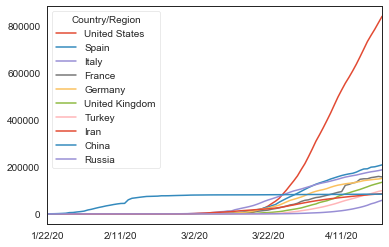

In [23]:
# Top 10 position by country
columns = confirmed_position_df.columns
confirmed_position_df[columns[:10]].plot()

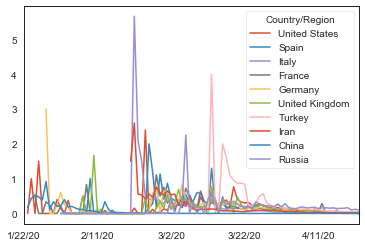

In [24]:
# Top 10 velocity by country
columns = confirmed_velocity_df.columns
confirmed_velocity_df[columns[:10]].plot()

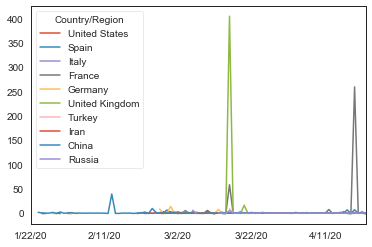

In [25]:
# Top 10 acceleration by country
columns = confirmed_acceleration_df.columns
confirmed_acceleration_df[columns[:10]].plot()

## Creating Cluster on the basis of Positive Cases, GDP per capita, Population density

In [26]:
positive_cases = pd.read_csv('datasets/aggregated_counts.csv')
positive_cases.head(n=3)

,Unnamed: 0,Country/Region,Country Code,Lat,Long,Total Confirmed,Total Positives
0,0,Afghanistan,AFG,33.00,65.00,15197,13417.0
1,1,Albania,ALB,41.15,20.17,12060,11433.0
2,2,Algeria,DZA,28.03,1.66,46533,43575.0


In [27]:
gdp_density = pd.read_csv('datasets/gdp_per_capita_and_population_density.csv')
gdp_density.rename(columns={"GDP per capita (current US$)":"GDP per capita"}, inplace=True)
data = pd.merge(positive_cases,gdp_density,left_on='Country Code', right_on='Country Code')
data.head(n=3)

,Unnamed: 0_x,Country/Region,Country Code,Lat,Long,Total Confirmed,Total Positives,Unnamed: 0_y,Country Name,GDP per capita,Population density
0,0,Afghanistan,AFG,33.00,65.00,15197,13417.0,1,Afghanistan,637,49
1,1,Albania,ALB,41.15,20.17,12060,11433.0,3,Albania,4413,105
2,2,Algeria,DZA,28.03,1.66,46533,43575.0,58,Algeria,5499,16


In [28]:
populations_data = pd.read_csv('datasets/Populations_and_popdensity.csv')
data = pd.merge(data, populations_data,left_on='Country/Region', right_on='Country/Region')
data = data.drop(['Unnamed: 0_x','Country/Region','Unnamed: 0_y', 'Total Confirmed','Population density'], axis=1)
data.head(n=3)

,Country Code,Lat,Long,Total Positives,Country Name,GDP per capita,Population,Density,Urban Population
0,AFG,33.00,65.00,13417.0,Afghanistan,637,38928346,60,9732086.50
1,ALB,41.15,20.17,11433.0,Albania,4413,2877797,105,1813012.11
2,DZA,28.03,1.66,43575.0,Algeria,5499,43851044,18,32011262.12


In [29]:
data['Total Positives'] = data['Total Positives'].apply(np.int64)
columns_titles = ["Country Name","Country Code","Total Positives","GDP per capita","Population","Density","Urban Population","Lat","Long"]
data = data.reindex(columns=columns_titles)
data['Urban Population'] = data['Urban Population'].apply(np.int64)

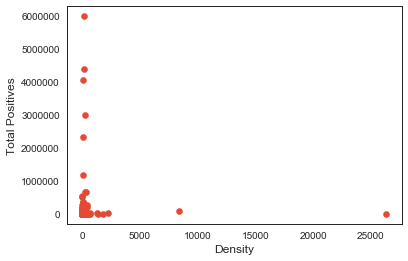

In [30]:
plt.scatter(data['Density'][:],data['Total Positives'][:])
plt.xlabel('Density')
plt.ylabel('Total Positives')
plt.show()

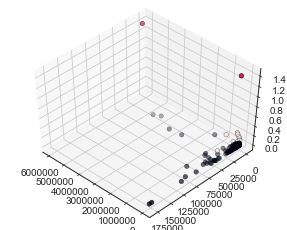

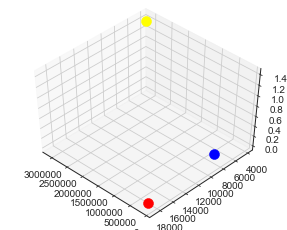

In [31]:
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['Total Positives','GDP per capita','Population']])
ax.scatter(data['Total Positives'], data['GDP per capita'], data['Population'], c=kmeans.labels_.astype(np.float), edgecolor='k')
cluster_centers = kmeans.cluster_centers_
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(cluster_centers[0,0],cluster_centers[0,1],cluster_centers[0,2], s=100, c='red')
ax.scatter(cluster_centers[1,0],cluster_centers[1,1],cluster_centers[1,2], s=100, c='yellow')
ax.scatter(cluster_centers[2,0],cluster_centers[2,1],cluster_centers[2,2], s=100, c='blue')

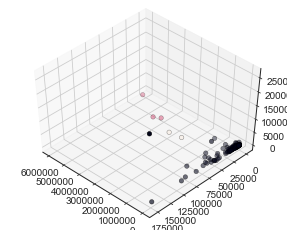

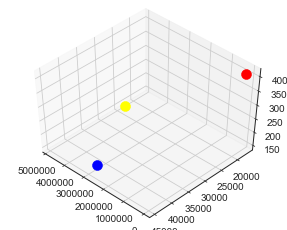

In [32]:
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['Total Positives','GDP per capita','Density']])
labels = kmeans.labels_
ax.scatter(data['Total Positives'], data['GDP per capita'], data['Density'], c=labels.astype(np.float), edgecolor='k')
cluster_centers = kmeans.cluster_centers_
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(cluster_centers[0,0],cluster_centers[0,1],cluster_centers[0,2], s=100, c='red')
ax.scatter(cluster_centers[1,0],cluster_centers[1,1],cluster_centers[1,2], s=100, c='yellow')
ax.scatter(cluster_centers[2,0],cluster_centers[2,1],cluster_centers[2,2], s=100, c='blue')

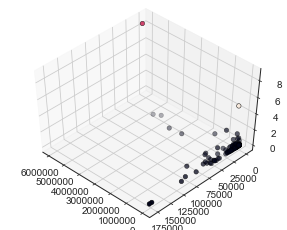

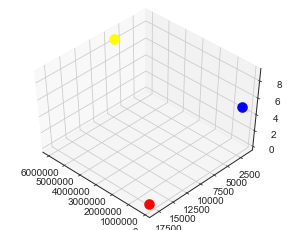

In [33]:
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['Total Positives','GDP per capita','Urban Population']])
labels = kmeans.labels_
ax.scatter(data['Total Positives'], data['GDP per capita'], data['Urban Population'], c=labels.astype(np.float), edgecolor='k')
cluster_centers = kmeans.cluster_centers_
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(cluster_centers[0,0],cluster_centers[0,1],cluster_centers[0,2], s=100, c='red')
ax.scatter(cluster_centers[1,0],cluster_centers[1,1],cluster_centers[1,2], s=100, c='yellow')
ax.scatter(cluster_centers[2,0],cluster_centers[2,1],cluster_centers[2,2], s=100, c='blue')

# Plotting Correlation based on Population, GDP,Population Density and Urban Population

In [34]:
total_confirmed_df.head()

,Country/Region,Lat,Long,Total Confirmed
0,Afghanistan,33.835231,66.004734,15295.0000
1,Albania,41.142450,20.049834,12121.3216
2,Algeria,28.158938,2.617323,46562.6935
3,Andorra,42.542291,1.560544,16033.0281
4,Angola,-12.293361,17.537368,446.6712


In [35]:
#Getting the total postives count from the csv
total_positives_df = pd.read_csv('datasets/aggregated_counts.csv',usecols=['Country/Region','Total Positives'])
total_positives_df.head()

,Country/Region,Total Positives
0,Afghanistan,13417.0
1,Albania,11433.0
2,Algeria,43575.0
3,Andorra,15314.0
4,Angola,409.0


In [36]:
#Merging the datasets to plot correlation heatmaps
covid_df = pd.merge(total_confirmed_df,total_positives_df,on='Country/Region')
covid_df.head()

,Country/Region,Lat,Long,Total Confirmed,Total Positives
0,Afghanistan,33.835231,66.004734,15295.0000,13417.0
1,Albania,41.142450,20.049834,12121.3216,11433.0
2,Algeria,28.158938,2.617323,46562.6935,43575.0
3,Andorra,42.542291,1.560544,16033.0281,15314.0
4,Angola,-12.293361,17.537368,446.6712,409.0


In [37]:
#Merging the country data of population, dgp and urban population count
final_covid_df = pd.merge(covid_df, populations_data,on='Country/Region')
final_covid_df.head()

,Country/Region,Lat,Long,Total Confirmed,Total Positives,Population,Density,Urban Population
0,Afghanistan,33.835231,66.004734,15295.0000,13417.0,38928346,60,9732086.50
1,Albania,41.142450,20.049834,12121.3216,11433.0,2877797,105,1813012.11
2,Algeria,28.158938,2.617323,46562.6935,43575.0,43851044,18,32011262.12
3,Andorra,42.542291,1.560544,16033.0281,15314.0,77265,164,67993.20
4,Angola,-12.293361,17.537368,446.6712,409.0,32866272,26,22020402.24


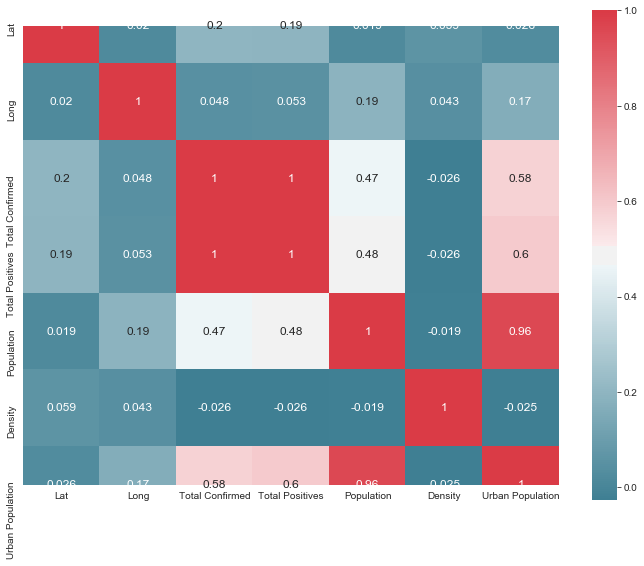

In [38]:
plot_correlation_map(final_covid_df)

# Trying to create a Merge plot based on all the data columns in the DataFrame

In [40]:
#Creating clusters based on all the columns in the dataframe
from sklearn.cluster import MeanShift,estimate_bandwidth
from iso3166 import countries
temp_df = final_covid_df
temp_df['Country/Region'] = final_covid_df['Country/Region'].apply(lambda x: int(countries.get(x).numeric))
clustering_df = temp_df.to_numpy()
bandwidth = estimate_bandwidth(clustering_df, quantile=0.2, n_samples=500)
mean_shift_clusters = MeanShift(bandwidth=bandwidth,n_jobs=5,max_iter=350).fit(clustering_df)

ModuleNotFoundError: No module named 'pycountry'

In [ ]:
labels = mean_shift_clusters.labels_
cluster_centers = mean_shift_clusters.cluster_centers_
labels_unique = np.unique(labels)
clusters = len(labels_unique)

In [ ]:
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(clusters), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(clustering_df[my_members, 0], clustering_df[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % clusters)
plt.show()